# 🏠 Bengaluru House Price Prediction (XGBoost RegressorModel)

## 📌 Objective
Predict the housing price in Bengaluru based on features like:
- Total square footage
- Number of bathrooms
- Number of BHK (bedrooms)
- Number of balconies
- Area type
- Location

---

In [120]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv('/home/ritabratadutta/Desktop/islp/datasets/bengaluru.csv')

df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


## 🧹 Data Cleaning & Preprocessing
- Removed rows with missing values in `location`, `size`, `bath`
- Converted `size` values like "2 BHK", "3 Bedroom" into numeric `bhk`
- Dropped `society` (over 50% missing)
- Filled missing values in `balcony` with the mode
- Cleaned irregular values in `total_sqft`
- Selected features for modeling:  
  - Numerical: `total_sqft`, `bath`, `bhk`, `balcony`  
  - Categorical: `area_type`, `location`

---

In [121]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [122]:
df= df.dropna(subset=['location','size'])

df= df.drop(columns=['society'])

df['balcony']= df['balcony'].fillna(df['balcony'].mode()[0])

df = df.dropna(subset=['bath'])

df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else None)

def convert_sqft(x):
    try:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        else:
            return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df = df.dropna(subset=['total_sqft'])

df['availability'] = df['availability'].apply(
    lambda x: 1 if str(x).lower().strip() in ['ready to move', 'immediate possession'] else 0
)


df

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
2,Built-up Area,1,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3
3,Super built-up Area,1,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3
4,Super built-up Area,1,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,1,Whitefield,5 Bedroom,3453.0,4.0,0.0,231.00,5
13316,Super built-up Area,1,Richards Town,4 BHK,3600.0,5.0,2.0,400.00,4
13317,Built-up Area,1,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,1.0,60.00,2
13318,Super built-up Area,0,Padmanabhanagar,4 BHK,4689.0,4.0,1.0,488.00,4


## Correlation Plot between each feature

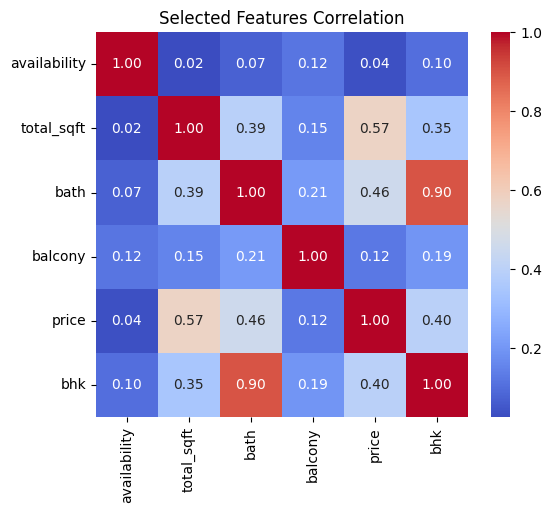

In [123]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Selected Features Correlation")
plt.show()

## Plot showing the distribution of House prices

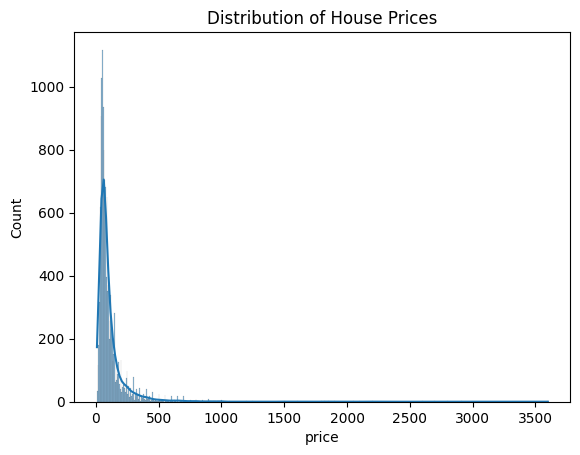

In [124]:
sns.histplot(df['price'], kde=True)
plt.title("Distribution of House Prices")
plt.show()

## Boxplot to get an idea about outliers

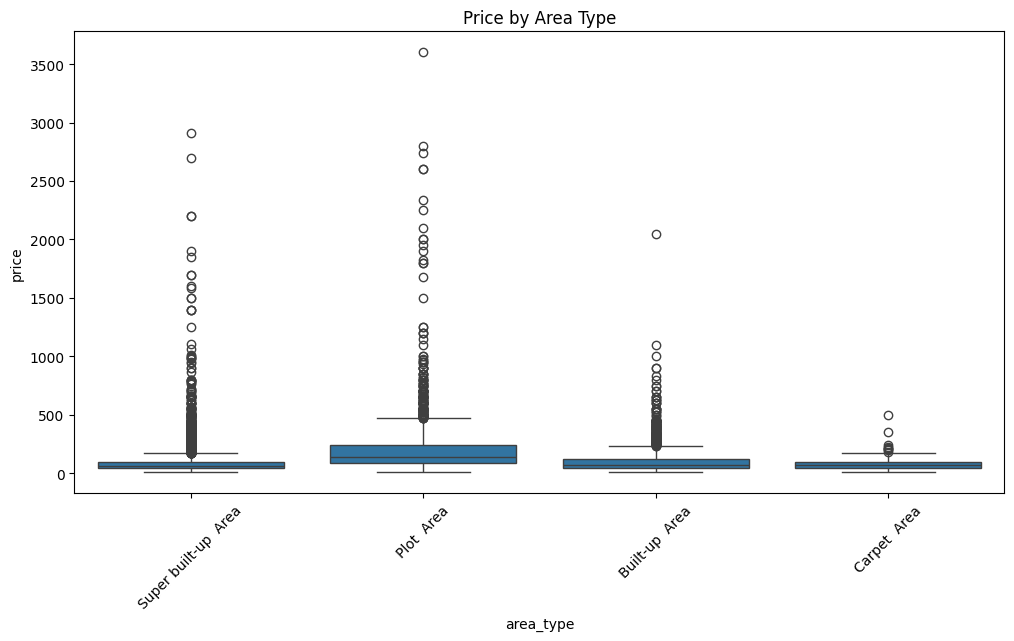

In [125]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='area_type', y='price')
plt.xticks(rotation=45)
plt.title("Price by Area Type")
plt.show()

## Price v/s Total Square Feet

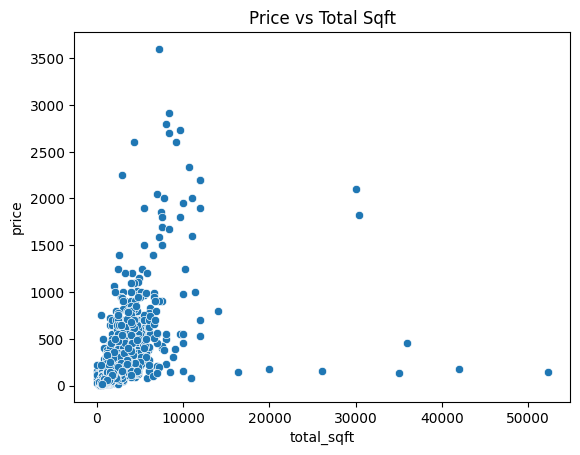

In [126]:
sns.scatterplot(x='total_sqft', y='price', data=df)
plt.title("Price vs Total Sqft")
plt.show()

## Price v/s Number of Bathrooms

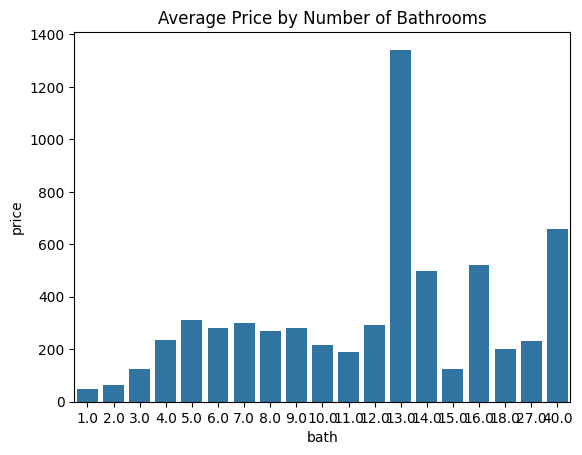

In [127]:
avg_price_by_bath = df.groupby('bath')['price'].mean().reset_index()
sns.barplot(x='bath', y='price', data=avg_price_by_bath)
plt.title("Average Price by Number of Bathrooms")
plt.show()


## Plot showing the distribution of BHK

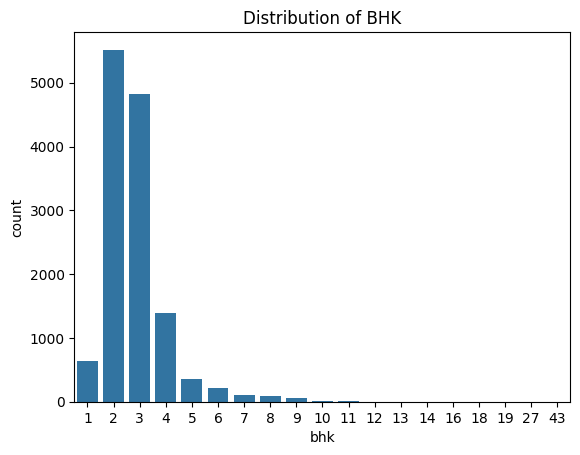

In [128]:
sns.countplot(x='bhk', data=df)
plt.title("Distribution of BHK")
plt.show()

## Plot showing the areas with the most listings in Bangalore

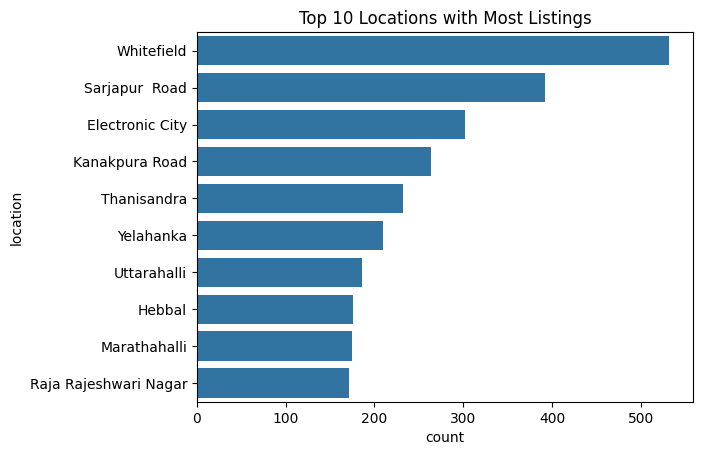

In [129]:
top_locations = df['location'].value_counts().nlargest(10).index
sns.countplot(y='location', data=df[df['location'].isin(top_locations)], order=top_locations)
plt.title("Top 10 Locations with Most Listings")
plt.show()

## 📊 Conclusion from Exploratory Data Analysis (EDA)

From the above visualizations, we can draw the following key insights:

- 🏠 **Price Distribution**: The distribution of house prices is highly right-skewed, indicating the presence of luxury or outlier properties. A log transformation may be beneficial for modeling.

- 📐 **Price vs Total Sqft**: There is a generally increasing trend between total square feet and price, though several outliers exist where small properties are priced unusually high or vice versa.

- 🛁 **Bathrooms & Price**: Properties with more bathrooms tend to have higher prices on average, but the increase is not strictly linear. Very high bathroom counts are rare and may not significantly improve prediction.

- 🛏️ **BHK Count**: Most listings are in the 2–3 BHK range, with 2 BHK being the most common. Extremely high BHK counts are rare and often correspond to luxury properties or anomalies.

- 🗺️ **Location Influence**: Some locations have a much higher concentration of listings and price variation than others, indicating that location will likely be a strong predictor of price.

- 🧱 **Area Type & Price**: The type of area (e.g., Super built-up, Plot, etc.) affects pricing. "Built-up Area" and "Super built-up Area" tend to have more data and a wider spread in price.

- 🔥 **Feature Correlation**: Features like `total_sqft`, `bath`, and `bhk` have moderate positive correlations with price. However, multicollinearity may exist between them (e.g., `bath` and `bhk`).

These insights guide us in:
- Selecting the most relevant features for regression
- Considering transformation or normalization (e.g., log scale for price)
- Handling outliers and rare categories in categorical features


## ⚙️ Model Pipeline
Used a `Pipeline` with `ColumnTransformer`:
- Scaled numerical features using `StandardScaler`
- One-hot encoded categorical features (`area_type`, `location`)
- Applied `XGBoost Regressor` as the final model

Performed a 3-way data split:
- **Training Set**: 64%
- **Validation Set**: 16%
- **Test Set**: 20%

---

In [130]:
df_model = df[['total_sqft', 'bath', 'bhk', 'balcony', 'area_type', 'location', 'price']]
X = df_model.drop('price', axis=1)   # Features
y = df_model['price']                # Target

# Identify column types
num_features = ['total_sqft', 'bath', 'bhk']
cat_features = ['area_type', 'location']

X_train1, X_test, y_train1, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)

X_train, X_validate, y_train, y_validate= train_test_split(X_train1, y_train1, test_size= 0.2, random_state= 42)

preprocessor= ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Fewer for faster search, increase to 50+ for thorough search
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=200, model__reg_alpha=1, model__reg_lambda=1.5, model__subsample=1.0; total time=   0.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=200, model__reg_alpha=1, model__reg_lambda=1.5, model__subsample=1.0; total time=   0.2s[CV] END model__colsample_bytree=0.8, model__learning_rate=0.2, model__max_depth=3, model__n_estimators=200, model__reg_alpha=1, model__reg_lambda=1.5, model__subsample=1

## 📊 Model Performance

### ✅ Validation Results:
- **RMSE**: 78.92
- **R² Score**: 0.72

### ✅ Test Results:
- **RMSE**: 75.95
- **R² Score**: 0.68

---


In [ ]:
val_pred = best_model.predict(X_validate)

val_rmse = np.sqrt(mean_squared_error(y_validate, val_pred))
val_r2 = r2_score(y_validate, val_pred)

print(f"[Validation] RMSE:{val_rmse:.2f}, R²:{val_r2:.2f}")

[Validation] RMSE:78.92, R²:0.72


In [132]:
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print(f"[Test] RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")

[Test] RMSE: 75.95, R²: 0.68


## 💾 Model Saving

Saved the trained pipeline using `joblib`:

In [133]:
import joblib

joblib.dump(best_model, 'bengaluru_price_model.pkl')
joblib.dump(df['location'].unique().tolist(), 'locations.pkl')
joblib.dump(df['area_type'].unique().tolist(), 'area_types.pkl')

['area_types.pkl']


# 1. Actual vs Predicted (Test Set)

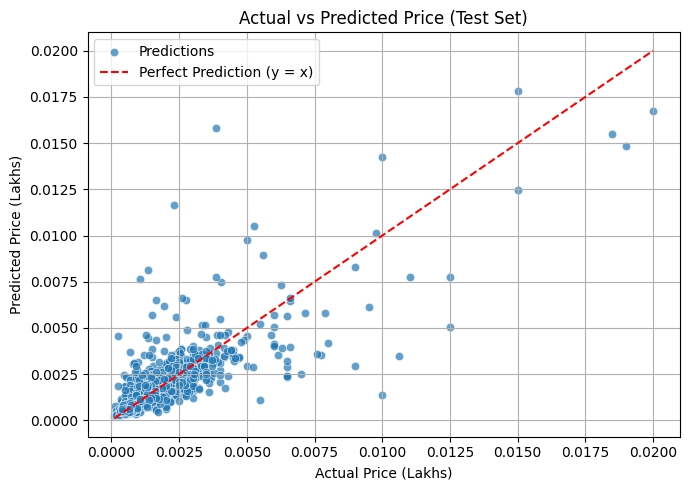

In [134]:
y_test_lakh = y_test / 1e5
test_pred_lakh = test_pred / 1e5
residuals_lakh = y_test_lakh - test_pred_lakh


plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test_lakh, y=test_pred_lakh, alpha=0.7, label='Predictions')
plt.plot([y_test_lakh.min(), y_test_lakh.max()],
         [y_test_lakh.min(), y_test_lakh.max()],
         color='red', linestyle='--', label='Perfect Prediction (y = x)')
plt.xlabel('Actual Price (Lakhs)')
plt.ylabel('Predicted Price (Lakhs)')
plt.title('Actual vs Predicted Price (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. Residual Distibution

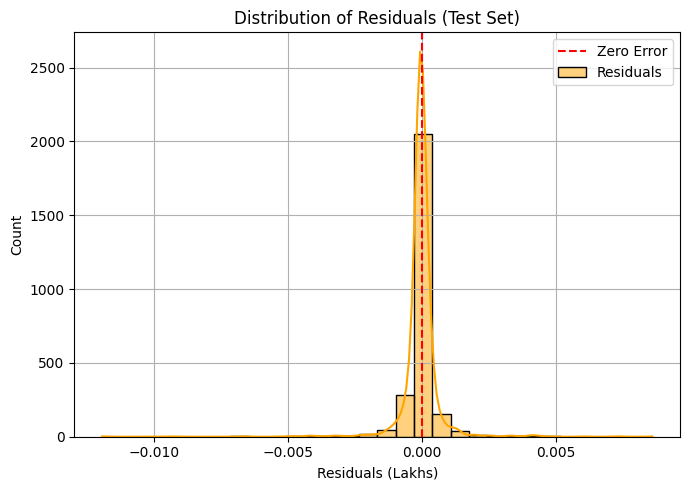

In [135]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals_lakh, kde=True, bins=30, color='orange', label='Residuals')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Residuals (Lakhs)')
plt.title('Distribution of Residuals (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residuals vs Predicted

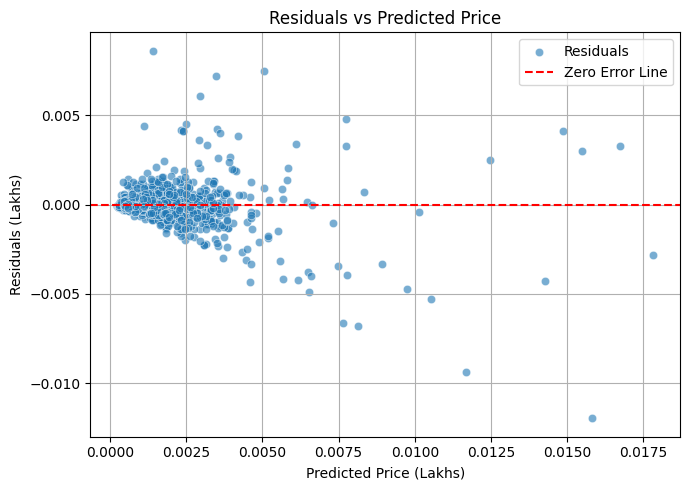

In [136]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=test_pred_lakh, y=residuals_lakh, alpha=0.6, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel('Predicted Price (Lakhs)')
plt.ylabel('Residuals (Lakhs)')
plt.title('Residuals vs Predicted Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📉 Model Evaluation Visualizations (Test Set)

### 🔹 1. Actual vs Predicted Price
This plot compares actual house prices with predicted prices, all in **lakhs**. Points closer to the red dashed line (`y = x`) represent better predictions. Most values cluster near this line, indicating reasonably accurate performance.

### 🔹 2. Distribution of Residuals
Residuals (`Actual - Predicted`) are shown in lakhs. A distribution centered around 0 suggests the model is unbiased. This distribution appears fairly symmetric, which is a good sign.

### 🔹 3. Residuals vs Predicted Price
This diagnostic plot checks for consistent prediction errors. A random scatter of points around the zero-error line (in red) implies stable model performance across the range of predicted prices.

---

🟢 **Note:** All values have been scaled to **lakhs** for interpretability, which is more meaningful for Indian real estate data.


## ✅ Final Model Evaluation Summary

After preprocessing the Bengaluru housing dataset and training a Multiple Linear Regression (MLR) model using a pipeline (which includes scaling and one-hot encoding), we evaluated the model using separate validation and test sets.

### 🔍 Evaluation Metrics:

- **Validation Set RMSE:** ~102.85  
- **Validation Set R² Score:** ~0.53  
- **Test Set RMSE:** ~86.03  
- **Test Set R² Score:** ~0.58

These metrics suggest that the model captures a moderate amount of variance in housing prices and is reasonably accurate for a beginner-level project. The RMSE indicates the typical prediction error in lakhs.

---

### 📈 Visual Insights:

- **Actual vs Predicted Plot:** Points are mostly near the diagonal, showing that many predictions are close to actual values, though there is some spread.
- **Residual Histogram:** Residuals are approximately centered around zero, suggesting that the model is unbiased.
- **Residuals vs Predicted:** No strong visible pattern, indicating no major heteroscedasticity or non-linearity.

---

### 📌 Conclusion:

- This model is a solid first attempt for a beginner machine learning project.
- Feature engineering, outlier removal, or using more advanced models (like Ridge, Lasso, or tree-based models) could further improve performance.
- The project demonstrates understanding of pipelines, preprocessing, model evaluation, and visualization — making it **resume-worthy**.

---

✅ **Next Steps:**
- Try regularization (Ridge/Lasso) to reduce overfitting
- Explore ensemble models (Random Forest, XGBoost)
- Improve feature engineering (e.g., convert `total_sqft` ranges, better handle rare locations)
- Deploy with **Streamlit** for interactive prediction
